In [9]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Rescaling, Input
from tensorflow.keras.optimizers import Adam

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Path to chess piece images
dataset_path = '/content/drive/MyDrive/Ali_Shuvo/flowers'
img_size = (224, 224)
batch_size = 32
seed = 42

In [6]:
# Load full dataset
full_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    image_size=img_size,
    batch_size=batch_size,
    seed=seed,
    shuffle=True  # Shuffle before splitting
)

Found 4327 files belonging to 5 classes.


In [7]:
# Split manually: 80% train, 20% test
dataset_size = len(full_ds)
train_size = int(0.8 * dataset_size)
test_size = dataset_size - train_size

train_ds = full_ds.take(train_size)
test_ds = full_ds.skip(train_size)

In [8]:
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomBrightness, RandomContrast

data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.2),
    RandomZoom(0.2),
    RandomBrightness(0.2),
    RandomContrast(0.2),
])

In [10]:
# Apply augmentation
augmented_train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y),
    num_parallel_calls=tf.data.AUTOTUNE
)

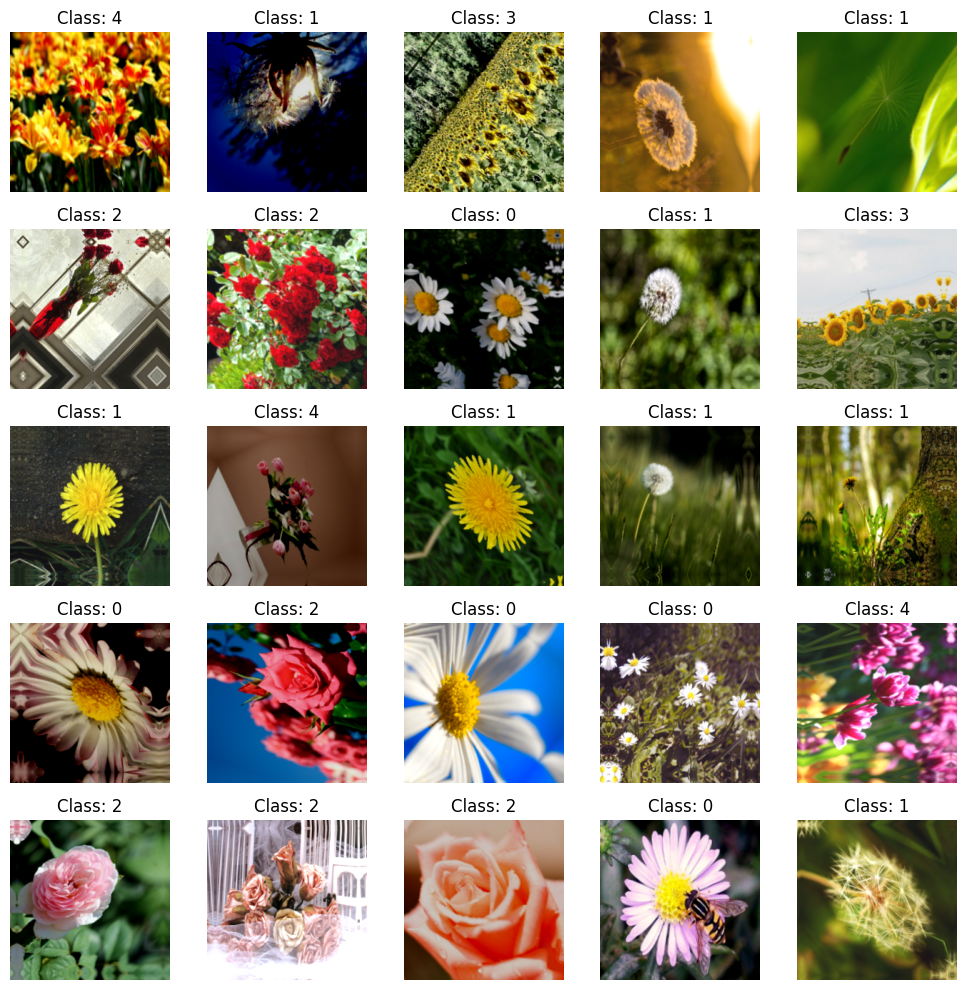

In [11]:
# Show Images

import matplotlib.pyplot as plt

# Take a single batch of images from the augmented training dataset
image_batch, label_batch = next(iter(augmented_train_ds))

# Number of images to display (25 in a 5x5 grid)
num_images_to_display = 25

# Create a 5x5 grid for the images
fig, axes = plt.subplots(5, 5, figsize=(10, 10))

# Iterate over the images in the batch
for i in range(num_images_to_display):
  ax = axes[i // 5, i % 5]  # Get the current subplot
  ax.imshow(image_batch[i].numpy().astype("uint8"))  # Display the image
  ax.set_title(f"Class: {label_batch[i].numpy()}")  # Set the class label as the title
  ax.axis("off")  # Turn off axes

plt.tight_layout()
plt.show()


In [12]:
# Prefetch
AUTOTUNE = tf.data.AUTOTUNE
augmented_train_ds = augmented_train_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

In [13]:
# Build Custom CNN model
model = Sequential([
    Input(shape=(img_size[0], img_size[1], 3), name='input_layer'),
    Rescaling(1./255),
    Conv2D(32, (5, 5), activation='relu'),
    MaxPooling2D((2,2)),
    MaxPooling2D((3,3)),
    Conv2D(16, (3, 3), activation='relu'),
    MaxPooling2D((2,2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(256, activation='relu'),
    Dense(len(full_ds.class_names), activation='softmax')
])

# Compile
model.compile(optimizer='Adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 220, 220, 32)   │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 110, 110, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 34, 34, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 15, 15, 64)     │         9,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 452,181 (1.72 MB)

 Trainable params: 452,181 (1.72 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
# Train
history = model.fit(augmented_train_ds, epochs=10)

Epoch 1/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 843s 8s/step - accuracy: 0.3472 - loss: 1.4681
Epoch 2/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 231s 2s/step - accuracy: 0.5422 - loss: 1.1311
Epoch 3/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 238s 2s/step - accuracy: 0.5917 - loss: 1.0179
Epoch 4/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 256s 2s/step - accuracy: 0.6082 - loss: 0.9638
Epoch 5/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 268s 2s/step - accuracy: 0.6209 - loss: 0.9435
Epoch 6/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 232s 2s/step - accuracy: 0.6536 - loss: 0.8872
Epoch 7/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 231s 2s/step - accuracy: 0.6597 - loss: 0.8493
Epoch 8/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 263s 2s/step - accuracy: 0.6701 - loss: 0.8365
Epoch 9/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 231s 2s/step - accuracy: 0.6702 - loss: 0.8233
Epoch 10/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 260s 2s/step - accuracy: 0.6919 - loss: 0.8117


In [15]:
# Test
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc:.2f}")

28/28 ━━━━━━━━━━━━━━━━━━━━ 136s 4s/step - accuracy: 0.6659 - loss: 0.8108
Test Accuracy: 0.66


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,138,757 (80.64 MB)

 Trainable params: 6,424,069 (24.51 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 2264s 21s/step - accuracy: 0.5243 - loss: 18.3188
Epoch 2/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 2281s 21s/step - accuracy: 0.7049 - loss: 0.7860
Epoch 3/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 2234s 21s/step - accuracy: 0.7644 - loss: 0.6236
Epoch 4/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 2228s 21s/step - accuracy: 0.7748 - loss: 0.6310
Epoch 5/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 2207s 20s/step - accuracy: 0.8242 - loss: 0.5250
Epoch 6/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 2246s 20s/step - accuracy: 0.8306 - loss: 0.4915
Epoch 7/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 2173s 20s/step - accuracy: 0.8395 - loss: 0.4846
Epoch 8/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 2181s 20s/step - accuracy: 0.8372 - loss: 0.4346
Epoch 9/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 2164s 20s/step - accuracy: 0.8548 - loss: 0.3979
Epoch 10/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 2176s 20s/step - accuracy: 0.8547 - loss: 0.3963
28/28 ━━━━━━━━━━━━━━━━━━━━ 541s 19s/step - accuracy: 0.8169 - loss: 0.6565
Test Accuracy: 0.81


KeyError: 'val_accuracy'

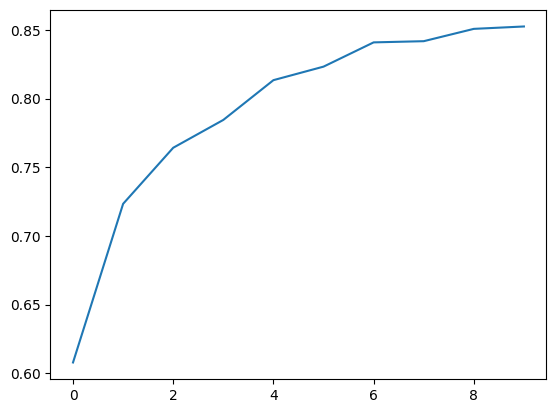

In [16]:
# Transfer Learning

import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten

# Load pre-trained VGG16 model (excluding top classification layers)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_size[0], img_size[1], 3))

# Freeze the base model layers
base_model.trainable = False

# Create a new model on top of the base model
model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dense(len(full_ds.class_names), activation='softmax')
])


# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

# Train the model
history = model.fit(augmented_train_ds, epochs=10)

# Evaluate the model
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc:.2f}")

# Plot accuracy
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.show()


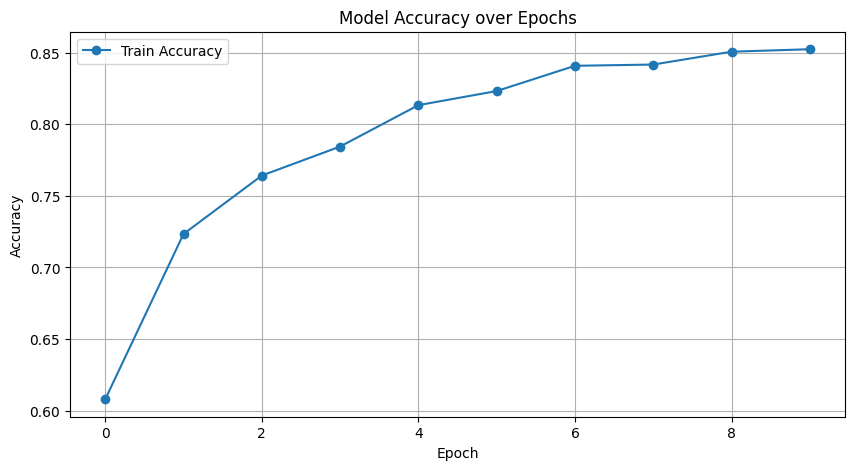

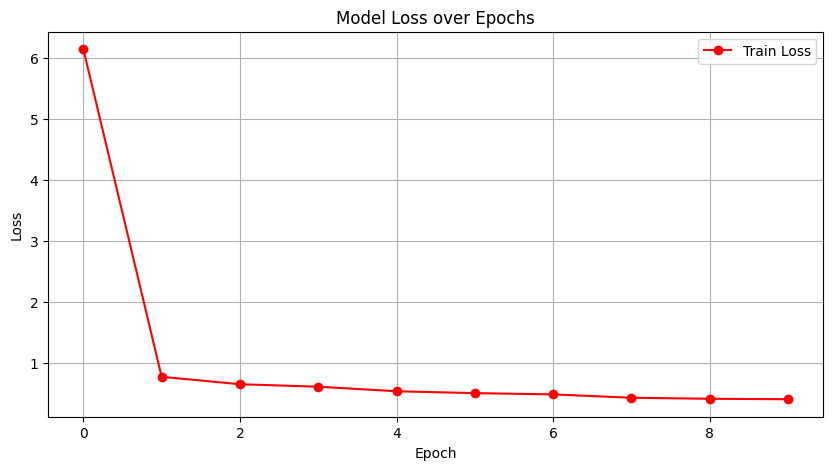

In [17]:
import matplotlib.pyplot as plt

# Accuracy Plot
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
if 'val_accuracy' in history.history:
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Model Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Loss Plot (Optional)
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss', marker='o', color='red')
if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'], label='Validation Loss', marker='o', color='orange')
plt.title('Model Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()
